# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

### Answer:
* Initial state: Empty board containing an 2D array of dots of size $m*n$. No lines are connected and no boxes are formed. It is player Max's turn.
* Actions: Place one line on available edge between two dots 
* Transition model: f(prev_state): action x prev_state = {all instances of prev_state with one additional line placed on a previously available edge (and potentially an additional box filled)} Swap turns IFF no new box was formed.
* Test for the terminal state: Player Max or Player Min has formed more than $\lfloor\frac{(m-1)(n-1)}{2}\rfloor+1$ boxes OR every possible line on the board has been filled by a player.
* Utility for terminal states: $Boxes(Max) - Boxes(Min)$, where $Boxes(p)$ is the number of boxes owned by player $p$.

How big is the state space? Give an estimate and explain it.

### Answer:

State Space Estimation: $|lines|$ * $|boxes|$, where $lines$ is the possible line configurations, and $boxes$ is the possible box configurations.

possible line configurations for board size n x m:
- ($|{empty, occupied}|^{(n-1)(m))+(n)(m-1))}$) -- Horizontal and vertical (2) orientatations -- $(n-1)*m$ horizontal lines can be placed, and $n*(m-1)$ vertical lines can be placed. Order of the lines matters (e.g. we must treat all boards with one line on it as separate states), so we perform a permutation calculation.

- e.g. for board size 5 x 3: # line configurations would be 2^22.

possible box configurations for board size n x m: 
- ($|{no initial, your box, opponent box}|^{(n-1)(m-1)}$) -- This is also a permutation calculation (same reasoning as above). 2 rows of $n$ dots allows $n-1$ boxes, and 2 rows of $m$ dots allows $m-1$ boxes.

- Full estimation: $2^{(n-1)(m))+(n)(m-1))} * 3^{(n-1)(m-1)}$. The line estimation is an accurate permutation. However, the fact that boxes are only possible based on specific configurations of lines (i.e. two horizontal lines adjacent to two vertical lines) forces the box estimation to be an upper bound.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

### Answer:

Depth $d$: Will be at most the number of possible places to place lines -- $(n-1)(m))+(n)(m-1))$.
Branching factor $b$: For given level $l$, $b$ is $(n-1)(m))+(n)(m-1))$ subtracted by $l$ (i.e. number of possible line positions minus the number of lines placed already).

Since we need to traverse all nodes, The game tree is in $O(b^d)$. Therefore the game tree is: $((n-1)(m))+(n)(m-1))-l)^{(n-1)(m))+(n)(m-1))}$.

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [161]:
import numpy as np

def empty_board(m = 4,n = 4):
    return {
    'n': n,  ### hoizontal dots
    'm': m   ### vertical dots
    }

board = {
    'n': 4,  ### hoizontal dots
    'm': 4   ### vertical dots
}

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['n'] + (orientation == 'v') or col >= board['m'] + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
            
    board[(orientation, row, col)] = True
    return True
    

print(draw_line(board, "h", 1, 1))
print(draw_line(board, "v", 1, 1))

# this hould not work
print(draw_line(board, "h", 1, 1))

board

True
True
False


{'n': 4, 'm': 4, ('h', 1, 1): True, ('v', 1, 1): True}

Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [162]:
# CODE ADOPTED AND MODIFIED FROM EDWARD JIANG'S DISCUSSION BOARD POST
# CODE ADOPTED AND MODIFIED FROM EDWARD JIANG'S DISCUSSION BOARD POST

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def show_board(board, show_results=False):
    n = board['n']  # Rows
    m = board['m']  # Columns
   
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, m-0.5)
    ax.set_ylim(-0.5, n-0.5)
   
    # Draw dots
    for row in range(n):
        for col in range(m):
            if (row, col) in board:
                ax.scatter(col, row, s=100, marker='o', color='black')
            else:
                ax.scatter(col, row, s=100, marker='o', color='black')
     
    # Draw lines
    for line in board:
        # print(line)
        if line != 'n' and line != 'm' and line != -1 and line != 1:
            # print(line)
            if len(line) > 2:
                # Draw Horizontal line
                if line[0] == 'h':
                    #print("for line ('h'",line[1],line[2],"), plot line from X=",line[2]+1,"to",line[2]+2,"and Y=",n-line[1],"to",n-line[1])
                    #l = mlines.Line2D([line[2]+1,line[2]+2], [n-line[1],n-line[1]], color='black')
                    l = mlines.Line2D([line[2],line[2]+1], [n-line[1]-1,n-line[1]-1], color='black')
                    ax.add_line(l)
                # Draw Vertical line
                elif line[0] == 'v':
                    #print("for line ('v'",line[1],line[2],"), plot line from X=",line[2]+1,"to",line[2]+1,"and Y=",n-line[1],"to",n-line[1]-1)                    
                    #l = mlines.Line2D([line[2]+1,line[2]+1], [n-line[1],n-line[1]-1], color='black')
                    l = mlines.Line2D([line[2],line[2]], [n-line[1]-2,n-line[1]-1], color='black')
                    ax.add_line(l)
   
    # Check for boxes
    # Boxes are stored in board with (row, col) as key and player (1 or -1) as value
    # eg: board[(3, 1)] = 1 -> player 1 has a box with top left vertex at (3, 1)
    for box in board:
        if box != 'n' and box != 'm' and box != -1 and box != 1:
            if len(box) == 2:
                if board[(box[0], box[1])] == 1:
                    ax.add_patch(plt.Rectangle((box[1], n - box[0] - 1), 1, -1, color='b'))
                    #print("blue box at point (",box[1],",",n - box[0] - 1,")")
                else:
                    ax.add_patch(plt.Rectangle((box[1], n - box[0] - 1), 1, -1, color='r'))
                    #print("red box at point (",box[1],",",n - box[0] - 1,")")
   
    # Print results  
    if (show_results):
        print('Results:')
        print('         -1:', board[-1])
        print('          1:', board[1])
   
    # Set up plot to start at (1, 1)
    x = []
    y = []
    for row in range(board['n']):
        # x.append(row)
        x.append(row+1)
    for col in range(board['m']):
        # y.append(col)
        y.append(col+1)
    default_x_ticks = range(len(x))
    plt.xticks(default_x_ticks, x)
    default_y_ticks = range(len(y))
    plt.yticks(default_y_ticks, y)
   
    plt.show()

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

__Notes:__
* Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).
* The result function evaluates if the player closed a box and needs to store that information on the board. Add elements of the form `(row,col): player` to the board dictionary. `row` and `col` are the coordinates for the box and `player` is +1 or -1 representing the player. For example `(0,0): -1` means that the top-left box belongs to the other player. 

The following are helper functions for checking for terminal states, and are used throughout the program.

They return lines (tuples of size 3) or boxes (tuples of size 2) from the given board `board`.

In [163]:
# Helper function to return all the boxes in a board owned by a player.
# Each box is a tuple of the form: (Box location, owner)
def get_boxes(board):

    boxes = []
    for key in board.keys():
        if (isinstance(key,tuple) and len(key) == 2):
            boxes.append(key)

    return boxes

# Helper function to return all the lines in the board.
def get_lines(board):
    lines = []
    for key in board.keys():
        if (isinstance(key,tuple) and len(key) == 3):
            lines.append(key)

    return lines

This result function updates the `board` dictionary by placing a line, then checking if that line formed a box. Only two box locations will be checked based on the provided `orientation` variable (`'h'` or `'v'`). If a box is detected, log it in `board` for the given player `player`.

DEBUG functionality is implemented to check whether boxes were successfully added to the dictionary.

In [164]:
# Referencing this paper as I go:
# https://www.aaai.org/ocs/index.php/AAAI/AAAI12/paper/viewFile/5126/5218#:~:text=Dots%2DAnd%2DBoxes%20is%20impartial,pieces%20of%20a%20certain%20color.

def result(board,orientation,row,col,player, DEBUG = 0):
    """
    Evaluates the state of the board, detecting and filling any unfilled boxes.
    Only searches for unfilled boxes based on the most recent line placed 
    (determined by params orientation, row, and col).
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    player
        whether player max (1) or player min (-1) placed the line
    
    """

    new_board = board.copy()

    # Place the line.
    new_board[(orientation,row,col)] = True

    # Check if boxes are formed, and place them.
    if (orientation == 'h'):
        # Horizontal case -- check if a box formed above (if possible)
        if (row > 0):
            if (('h',row-1,col) in new_board and 
                ('v',row-1,col) in new_board and
                ('v',row-1,col+1) in new_board ):
                
                if DEBUG >= 1: print("new box added above -- (",row-1,",",col,")")
                new_board[(row-1,col)] = player
        # Horizontal case -- check if a box formed below (if possible)
        if (row < new_board['n'] - 1):
            if (('h',row+1,col) in new_board and 
            ('v',row,col) in new_board and
            ('v',row,col+1) in new_board):

                if DEBUG >= 1: print("new box added below -- (",row,",",col,")")          
                new_board[(row,col)] = player

    elif (orientation == 'v'):
        # Vertical case -- check if a box formed to the left (if possible)
        if (col > 0):
            if (('v',row,col-1) in new_board and 
            ('h',row,col-1) in new_board and
            ('h',row+1,col-1) in new_board):
                
                if DEBUG >= 1: print("new box added left -- (",row,",",col-1,")")   
                new_board[(row,col-1)] = player

        # Vertical case -- check if a box formed to the right (if possible)
        if (row < new_board['m'] - 1):
            if (('v',row,col+1) in new_board and 
            ('h',row,col) in new_board and
            ('h',row+1,col) in new_board):

                if DEBUG >= 1: print("new box added right -- (",row,",",col,")")                  
                new_board[(row,col)] = player

    #print("BOARD UPDATED")
    #show_board(board)

    return new_board

$Utility = Boxes(Max)-Boxes(Min)$.

Given a board, this function calculates and returns $Utility$.

In [165]:
# Utility: Ratio of boxes Max owns to boxes Min owns.
def utility(board):

    DEBUG = 0

    utility = 0

    # Who owns what box?
    # Calculate utility by calculating Max - Min.
    for box in get_boxes(board):
        if DEBUG >= 2: print(box,"belongs to",board[box])
        if (board[box] == 1):
            if DEBUG >= 2: print("+",end='')
            utility += 1
        elif (board[box] == -1):
            if DEBUG >= 2: print("-",end='')
            utility -= 1

    if DEBUG >= 1: print("Utility calculated for a board: ",utility)

    # TODO: WE WANT TO ADD SOME REGULARIZATION TO THIS FUNCTION.
    return utility

Helper functions `check_win` and `check_board_full` are used to check for terminal nodes (in the `terminal` function), and stop playtime in the `play` function.

Node that the `terminal` function is used to specify leaf nodes in the Minimax Search game tree.

In [166]:
def check_win(board):
    """
    Helper function to check whether a player has placed enough boxes to guarantee a win 
    (i.e. guarantee ownership of more boxes than the other)
    """
    boxes = get_boxes(board)

    win_threshold = (board['m']-1)*(board['n']-1)//2 + 1

    # At any point, if it's determined that max or min has obtained 'win_threshold' boxes
    # Then return that player as the winner.
    # Otherwise, return 0 (No winner yet).
    min_cnt = 0
    max_cnt = 0
    for box in boxes:
        if board[box] == 1:
            max_cnt += 1
        elif board[box] == -1:
            min_cnt += 1
        
        if max_cnt >= win_threshold:
            return 1
        if min_cnt >= win_threshold:
            return -1


    return 0
    
def check_board_full(board):
    """
    Helper function to check whether the board is completely filled with
    lines (i.e. whether there are no more possible moves to make).
    """

    m = board['m']
    n = board['n']
    
    return len(get_lines(board)) >= m*(n-1) + n*(m-1)

def terminal(board):
    """
    Terminal function -- checks whether a given board state is a terminal
    node.
    """
    return check_win(board) or check_board_full(board)

Action function -- The agent can choose among any location from `board` that doesn't have a line placed already.

In [167]:
def actions(board):
    """
    Actions function -- returns positions of all possible lines the player can place.
    """
    res = []
    for i in range(board['n']):
        for j in range(board['m']):
            if (i == board['n']-1 and j == board['m']-1):
                continue
            if (('h',i,j) not in board and j != board['m']-1):
                res.append(('h',i,j))
            if (('v',i,j) not in board and i != board['n']-1):
                res.append(('v',i,j))

    return res

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [168]:
# Random player agent function.
# Adopted and modified from tictactoe_interactive.ipynb.
def random_player(board, player=None, order_fun = None):
    possible_actions = actions(board)
    return possible_actions[np.random.choice(len(possible_actions),1)[0]]

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

The play function simulates `N` games from a given `start_board`. The function also handles the following:

- Allowing two different agent functions to alternate performing actions on a single common board. This consists of:
- Turn handling.
- Handling successive turns (if one player fills a box, they can take another turn).
- Stopping playtime when a given player wins or a draw occurs.

In [194]:
# Given a player and one of its agent functions, return the other player's signature and its agent function.
def switch_player(player, pfun1, pfun2):
    if player == 1:
        return -1, pfun2
    elif player == -1:
        return 1, pfun1

# Your code/ answer goes here.
def play(pfun1, pfun2, N = 1, show_final_board = False, start_board = empty_board(), print_moves = False):
    """Let two agents play each other N times. red starts. red and blue are agent functions that 
    get the board as the percept and return their next action.
    
    Code Adopted and modified from tictactoe_interactive.ipynb.
    """
    results = {1: 0, -1: 0, 0: 0}
    
    # Skip flag. If one player forms a box, the other player's turn is skipped.
    skip = False

    for i in range(N):
        board = start_board.copy()
        player, fun = 1, pfun1
        
        while True:
            action = fun(board, player)

            if print_moves: print("Player",player,"placed line (",action[0],action[1],action[2],")")
            # Update the board, and note whether the player's move created a new box.
            boxes_before = len(get_boxes(board))
            board = result(board, action[0], action[1], action[2], player)
            boxes_after = len(get_boxes(board))

            if boxes_before - boxes_after != 0:
                skip = True
                if print_moves: print("Player",player,"filled a box! Player",other(player),"'s turn skipped")

            # Did the player win?
            win = check_win(board)   # returns the 'n' if the game is not done.
            if win != 0:
                results[win] += 1
                if show_final_board: 
                    print("Final board:")
                    show_board(board)
                break

            # Also end the game if the board is full.
            if check_board_full(board):
                results[0] += 1
                break
            
            # We only switch players if the other player was not skipped.
            if skip == False:
                player, fun = switch_player(player, pfun1, pfun2)
            else:
                skip = False
    
    return results

Final board:


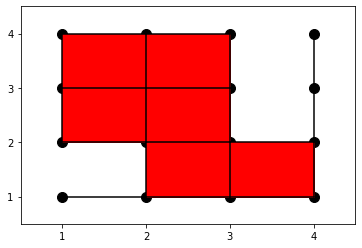

Final board:


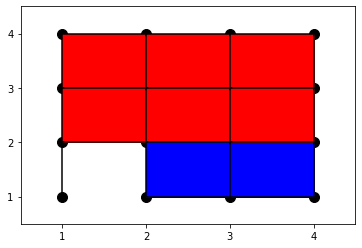

Final board:


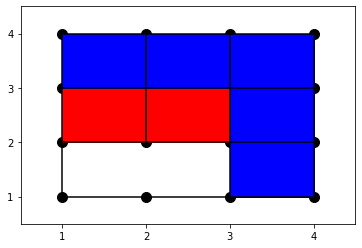

Final board:


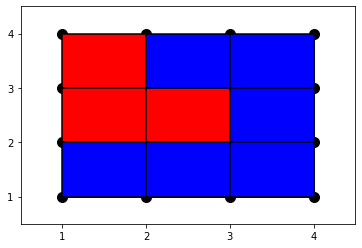

Final board:


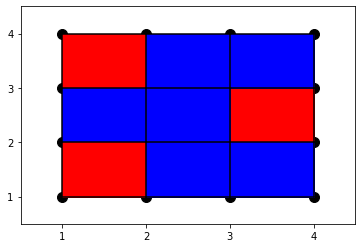

Blue (1) Wins: 3
Red (-1) Wins: 2


In [170]:
# Demo: Play 5 games and display the final boards.
results = play(random_player, random_player, N = 5,show_final_board=True)
print("Blue (1) Wins:",results[1])
print("Red (-1) Wins:",results[-1])

We then let the agents play 1000 times and display the results.

In [171]:
# Run the random agents 1000 times and display the results.
results = play(random_player, random_player, N = 1000,show_final_board=False)
print("Blue (1) Wins:",results[1])
print("Red (-1) Wins:",results[-1])
print("Draws:",results[0])

Blue (1) Wins: 503
Red (-1) Wins: 497
Draws: 0


### Observations:

The players appear to be evenly matched, meaning that it doesn't really matter which player goes first. These results aren't particularly surprising since the agents are random, and there are enough possible moves such that a player can make a move that drastically decreases its chances of winning, even nearing the end of the game.

## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

In [172]:
# Given a player, return the signature of its opponent.
def other(player): 
    if player == -1: return 1
    else: return -1

In [229]:
import math
    
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

# Implementation of Minimax Search with Alpha Beta Pruning.
# Adopted and modified from tictactoe_alpha_beta_tree_search.ipynb.
def alpha_beta_search(board, player = 1, order_fun = None, frankensearch = False):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf, order_fun = order_fun, frankensearch = frankensearch)
     
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta, frankensearch = False, order_fun = None):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility if state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if terminal(state): return v, None
        
    v, move = -math.inf, None

    possible_actions = actions(state)
    
    # Create a move ordering function, if one is supplied.
    if order_fun is not None:
        order_fun(possible_actions,state)

    # Implement FRANKENSEARCH if called for -- look at only the leftmost 3 actions.
    if frankensearch:
        possible_actions = possible_actions[:2]

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in possible_actions:
        v2, a2 = min_value_ab(result(state, a[0], a[1], a[2], other(player)), player, alpha, beta, order_fun = order_fun, frankensearch = frankensearch)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta, order_fun = None, frankensearch = False):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility if state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if terminal(state): return v, None
    
    v, move = +math.inf, None

    possible_actions = actions(state)
    
    # Create a move ordering function, if one is supplied.
    if order_fun is not None:
        order_fun(possible_actions,state)

    # Implement FRANKENSEARCH if called for -- look at only the leftmost 3 actions.
    if frankensearch:
        possible_actions = possible_actions[:2]

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in possible_actions:
        v2, a2 = max_value_ab(result(state, a[0], a[1], a[2], other(player)), player, alpha, beta, order_fun = order_fun, frankensearch = frankensearch)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

In [174]:
# Your code/ answer goes here.
def alpha_beta_search_player(board, player=None, order_fun=None):
    return alpha_beta_search(board.copy(),player = player, order_fun=order_fun)["move"]

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

The 5 boards below test for the following:

- Board 0: Does the player claim a box when a C shape is available?
- Board 1: Does the player prevent a C shape that the opponent can use to fill in a box for themselves?
- Board 2: Does the player claim an available box and prevent a C shape on its next turn?
- Board 3: Does the player create an L shape (or parallel line) when given an opportunity to do so?
- Board 4: Does the player fill two boxes when given the opportunity?

Player can claim a box and win


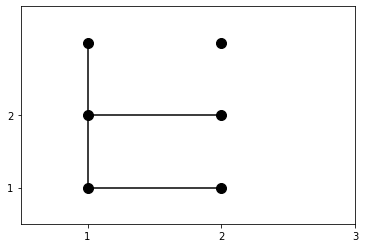

Player can avoid a C shape for the opponent


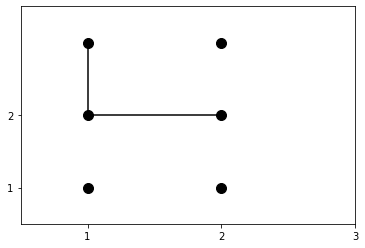

Player can fill a box and prevent a C shape


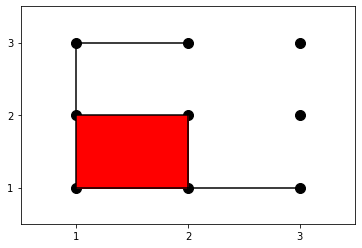

Player can create an L shape


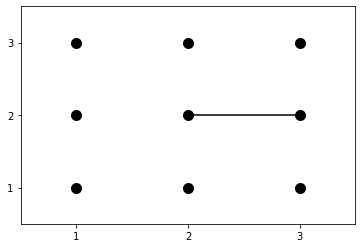

Player can fill two boxes


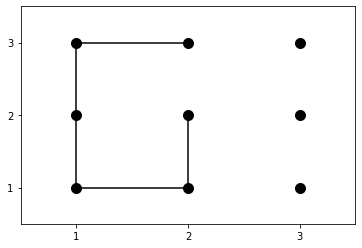

In [175]:
# Your code/ answer goes here.
boards = []
for i in range(5):
    boards.append({'n': 3,'m': 2})

# Define board 0 lines.
boards[0]['h',1,0] = True
boards[0]['h',2,0] = True
boards[0]['v',0,0] = True
boards[0]['v',1,0] = True
print('Player can claim a box and win')
show_board(boards[0])

# Define board 1 lines.
boards[1]['v',0,0] = True
boards[1]['h',1,0] = True
print('Player can avoid a C shape for the opponent')
show_board(boards[1])

# Define board 2 lines.
boards[2]['m'] = 3
boards[2]['v',0,0] = True
boards[2]['v',1,0] = True
boards[2]['v',1,1] = True
boards[2]['h',0,0] = True
boards[2]['h',1,0] = True
boards[2]['h',2,0] = True
boards[2]['h',2,1] = True
# Define board 2 box.
boards[2][(1,0)] = -1
print('Player can fill a box and prevent a C shape')
show_board(boards[2])

# Define board 3 lines.
boards[3]['m'] = 3
boards[3]['h',1,1] = True
print('Player can create an L shape')
show_board(boards[3])

# Define board 4 lines.
boards[4]['m'] = 3
boards[4]['v',0,0] = True
boards[4]['v',1,1] = True
boards[4]['v',1,0] = True
boards[4]['h',0,0] = True
boards[4]['h',2,0] = True
print('Player can fill two boxes')
show_board(boards[4])

In [203]:
def switch_player(player, pfun1, pfun2):
    if player == 1:
        return -1, pfun2
    elif player == -1:
        return 1, pfun1

# Your code/ answer goes here.
def test_move(fun, N = 1, show_res_board = False, start_board = empty_board(), order_fun = None, DEBUG = 0):
    """Run 'fun' N times on a given start_board. Return the ratio of optimal moves made to total moves made.
    
    Code Adopted and modified from tictactoe_interactive.ipynb.
    """

    # Counts the number of optimal moves made in each of the N games.
    # (We can run this N times if there's a stochastic element in pfun1).
    optimal_cnt = 0

    for i in range(N):
        init_board = start_board.copy()
        player = 1
        
        if DEBUG >= 2: 
            print("For initial board:")
            show_board(init_board)

        boxes_before = -2
        boxes_after = -1

        # If the player's move creates a box, let the player make another move.
        while boxes_before - boxes_after != 0:

            boxes_before = len(get_boxes(init_board))

            # Record the agent's action and utility.
            action = fun(init_board, player, order_fun = order_fun)
            board_with_move = result(init_board, action[0], action[1], action[2], player)
            if DEBUG >= 2: print("Made move (",action[0], action[1], action[2],")")
            v = utility(board_with_move)

            # Note whether the player's move created a new box.
            boxes_after = len(get_boxes(board_with_move))

            # Enumerate all possible actions and record their utilities, sorted in ascending order.
            possible_actions = actions(init_board)

            utilities = []

            for a in possible_actions:
                if DEBUG >= 1: print("Can place the line (",a[0], a[1], a[2],") with utility",utility(result(init_board, a[0], a[1], a[2], player)))
                utilities.append(utility(result(init_board, a[0], a[1], a[2], player)))
            utilities.sort()

            # Did the agent make an optimal move?
            if v == utilities[-1]:
                optimal_cnt += 1

            # Update the board in case we make another move on it.
            init_board = board_with_move

            # Show the move.
            if (show_res_board): show_board(board_with_move) 

    return optimal_cnt / N


Like the Alpha Beta Tree Search algorithm currently struggles against these test cases and needs tuning. Much of these can be fixed with a better utility function, as 3/5 of these cases were (correctly) flagged as "optimal" (since there were no changes in the number of boxes owned by either player).

The Search correctly filled in a box and prevented a C shape (Board 2), but failed to:

- Fill a box.
- Fill two boxes.
- Avoid placing a C shape.
- Form an L shape or a parallel line.

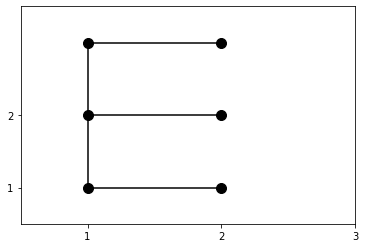

Alpha beta tree search did not perform the optimal move for Board 0


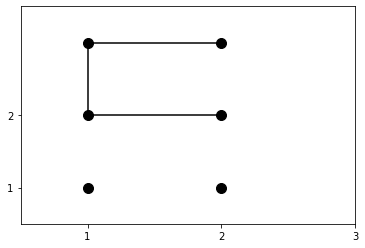

Alpha beta tree search performed 1 optimal move(s) for Board 1


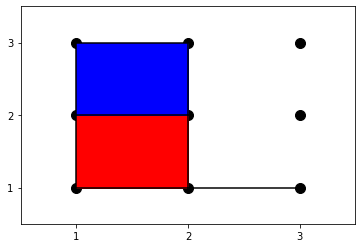

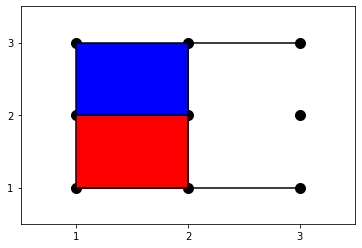

Alpha beta tree search performed 2 optimal move(s) for Board 2


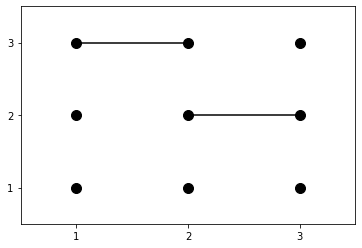

Alpha beta tree search performed 1 optimal move(s) for Board 3


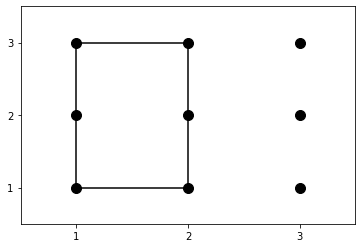

Alpha beta tree search did not perform the optimal move for Board 4


In [208]:
# Run the agent on each.
for i, curr_board in enumerate(boards):
    is_optimal = test_move(alpha_beta_search_player, start_board=curr_board, show_res_board=True)
    if (is_optimal >= 0.995):
        print("Alpha beta tree search performed",int(is_optimal),"optimal move(s) for Board",i)
    else:
        print("Alpha beta tree search did not perform the optimal move for Board",i)

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

Timing data is displayed in the printouts below. Minimax Search with alpha beta pruning can reasonably solve games up to 3x3. When running a board any larger, it takes many minutes to make a single move.

In [222]:
import time 

# Your code/ answer goes here.
board_sizes = [(2,2),(2,3),(3,3)]

for board_size in board_sizes:
    t_i = time.time()
    test_move(alpha_beta_search_player,start_board=empty_board(board_size[0],board_size[1]), N=10)
    t_f = time.time()
    print("A %s board took %.5f seconds to make a move 10 times." % (board_size,t_f-t_i))

A (2, 2) board took 0.00200 seconds to make a move 10 times.
A (2, 3) board took 0.06300 seconds to make a move 10 times.
A (3, 3) board took 13.80783 seconds to make a move 10 times.


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

Move ordering consistently reduces (3,3) board move placement times by about 25% on average. (13 -> 10 seconds). See table below.

Note that two move ordering strategies are introduced. 

1. Order the moves based on whether the moves add a box.
2. Order the moves based on whether the line placements are closer to the center of the screen.

For this timing demo, only the second strategy is compared since we test 1 move on an empty board (thus making ordering based on the first strategy "useless").

In [210]:
# Your code/ answer goes here.
# Move ordering strategy -- does my move create a new box?
def move_ordering_1(possible_moves, board):

    boxes_difference = lambda move: len(get_boxes(result(board, move[0], move[1], move[2], player = 1))) - len(get_boxes(board))

    possible_moves.sort(key=boxes_difference)

# Move ordering strategy -- is my move as close to the center of the board as possible (rounded down)?
# We introduce both ordering functions because both would appear to be effective, but for testing a single move on an empty board,
# only move_ordering_2 would produce any actual ordering (Since producing a box on an empty board with 1 move is impossible).
def move_ordering_2(possible_moves, board):

    n = board['n']
    m = board['m']

    n_center =  n // 2
    m_center = m // 2

    pos_difference = lambda move: abs(move[1] - n_center) + abs(move[2] - m_center)

    possible_moves.sort(key=pos_difference)
    

In [211]:
for board_size in board_sizes:
    t_i = time.time()
    test_move(alpha_beta_search_player,start_board=empty_board(board_size[0],board_size[1]), order_fun=move_ordering_2, N=10)
    t_f = time.time()
    print("A %s board took %.5f seconds to make a move 10 times." % (board_size,t_f-t_i))

A (2, 2) board took 0.00200 seconds to make a move 10 times.
A (2, 3) board took 0.06400 seconds to make a move 10 times.
A (3, 3) board took 10.61818 seconds to make a move 10 times.


Time in seconds for Alpha Beta Tree search to make a move (repeated 10 times).
No Move Ordering vs Move Ordering (using the Move Ordering 2 strategy) are compared.

| Size     | No Move Ordering |  With Move Ordering |
|----------|------------------|---------------------|
| 2x2     | 0.001 s | 0.002 s |
| 2x3   | 0.045 s | 0.066 s |
| 3x3 | 13.94 s | 10.69 s |

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

Most of the logical solutions to reduce time have been discussed above -- move ordering, alpha beta pruning, etc. In addition, providing a heuristic to cut off the game tree is discussed below.

Below is an implementation of an esoteric idea I call `frankensearch` (because it is a *hideous patchwork solution*) -- that is, after move ordering, look at only the first three actions extending from each layer. This will end up producing a massive preferential treatment towards move ordering from the agent.

It is definitely impractical as it will ignore possible outcomes that can improve utility. BUT it is far faster.

Demo below times Franksearch for a single move for board sizes 3x3, 3x4, and 4x4.

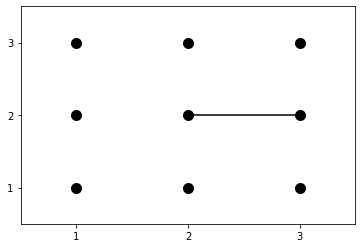

A (3, 3) board took 0.07200 seconds to make a move.


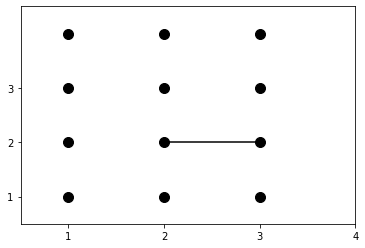

A (3, 4) board took 0.09400 seconds to make a move.


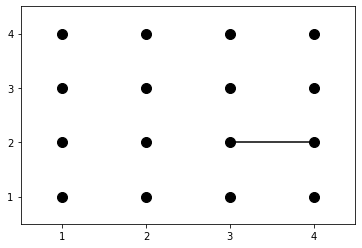

A (4, 4) board took 0.14900 seconds to make a move.


In [234]:
# Radical idea: After move ordering, only traverse the first three moves at every layer.
def alpha_beta_frankensearch_player(board, player=None, order_fun=None):
    return alpha_beta_search(board.copy(),player = player, frankensearch=True, order_fun=move_ordering_2)["move"]

# Test timing for this search on empty boards of size 3x3 and 3x4.
board_sizes = [(3,3),(3,4),(4,4)]

for board_size in board_sizes:
    t_i = time.time()
    test_move(alpha_beta_frankensearch_player,start_board=empty_board(board_size[0],board_size[1]), show_res_board=True)
    t_f = time.time()
    print("A %s board took %.5f seconds to make a move." % (board_size,t_f-t_i))

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

The Minimax Search agent does not consistently do much better than a random agent. This is likely because the search assumes optimal play from the opponent, but the opponent does not play optimally.

In [225]:
# Your code/ answer goes here.
results = play(alpha_beta_search_player, random_player, N = 15,show_final_board=False,start_board=empty_board(3,3))
print("Blue (1) Wins:",results[1])
print("Red (-1) Wins:",results[-1])
print("Draws:",results[0])

Blue (1) Wins: 6
Red (-1) Wins: 4
Draws: 5


## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [214]:
def count_C_shapes(board, DEBUG = 0):
    """Given all sets of "boxes" in the board,
    return now many boxes form C shapes."""

    n = board['n'] # Number of rows
    m = board['m'] # Number of columns

    count = 0

    for row in range(n):
        for col in range(n):
            num_lines = 0

            # Checks the 4 lines that form a box
            if ('h',row,col) in board: num_lines +=1
            if ('v',row,col) in board: num_lines +=1
            if ('h',row+1,col) in board: num_lines +=1
            if ('v',row,col+1) in board: num_lines +=1

            if (num_lines == 3): 
                count += 1
                
    return count

def count_L_II_shapes(board):
    """Given all sets of "boxes" in the board,
    return now many boxes form L shapes or
    parallel line (||) shapes."""

    n = board['n'] # Number of rows
    m = board['m'] # Number of columns

    count = 0
    
    # For each dot in the board (representing top left of a box...)
    for row in range(n):
        for col in range(n):
            num_lines = 0

            # Checks the 4 lines that form a box
            for h in [(0,'h'),(1,'v')]:
                for v in [0,1]:
                    # FIXME: PROBABLY COMPLETELY WRONG
                    if (h[1],row+h[0],col+v) in board: num_lines +=1

            if (num_lines == 2): 
                count += 1

    return count

In [215]:
# Your code/ answer goes here.
def eval_fun(board, player = 1, w1 = 3, w2 = 2, w3 = 1, DEBUG = 0):
    """heuristic for utility of state. Returns score for a node:
    1. For terminal states it returns the utility. 
    2. For non-terminal states, it calculates a weighted linear function using 2 features of the state:
    - How many 'boxes' have 2 lines filled out (L shapes, or parallel lines). These shapes boost utility.
    - How many C shapes are found. C shapes reduce utility.
    - Weighted based on current utility (Boxes owned by max vs Boxes owned by min).

    We need to be careful that the utility of the heuristic stays between [-1,1]. 
    Note that the largest possible number of these positions is 4. I weigh the count by 0.1, 
    guaranteeing that is in the needed range.
    
    Adopted and Modified from tictactoe_heuristic_alpha_beta_tree_search.ipynb.

    Function Returns: heuistic value, terminal?"""
    # terminal state?
    u = utility(board)
    if terminal(board): return u, True
    
    # Determine Heuristic value.
    # w1, w2, and w3 modify functional components of the evaluation function.
    #   w1 - C shapes
    #   w2 - L shapes or parallel lines
    #   w3 - Current utility of this board
    if DEBUG >= 2: print(count_C_shapes(board),"C shaped found\n",count_L_II_shapes(board),"L/|| shapes found\n","Utility is",u)
    score = (w1 * count_L_II_shapes(board) - w2 * count_C_shapes(board)) + (w3 * u)
    if DEBUG >= 1: print("eval_fun score (For Heuristic AB Search):",score)

    return score, False

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [216]:
# Your code/ answer goes here.
import math
    
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

# Implementation of Minimax Search with Alpha Beta Pruning.
# Adopted and modified from tictactoe_alpha_beta_tree_search.ipynb.
def heuristic_ab_search(board, player = 1, cutoff = None, eval_fun = eval_fun):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    value, move = heuristic_max_value_ab(board, player, -math.inf, +math.inf, 0, cutoff, eval_fun)
     
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def heuristic_max_value_ab(state, player, alpha, beta, depth, cutoff, eval_fun):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = heuristic_min_value_ab(result(state, a[0], a[1], a[2], other(player)), player, alpha, beta, depth+1, cutoff, eval_fun)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def heuristic_min_value_ab(state, player, alpha, beta, depth, cutoff, eval_fun):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = heuristic_max_value_ab(result(state, a[0], a[1], a[2], other(player)), player, alpha, beta, depth+1, cutoff, eval_fun)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

In [217]:
# Your code/ answer goes here.
def heuristic_ab_search_player(board, player=None, order_fun = None):
    return heuristic_ab_search(board.copy(),player = player, cutoff=5)["move"]

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

Like the standard Alpha Beta Tree Search algorithm above, the Heuristic alpha beta tree search was caught being too perceptive, and did not take the "greedy" option of claiming a box when it was available. Either that or the utility function needs tuning.

Two other cases also failed. This is probably due to a utility function that doesn't detect these characteristics:
- It created a C shape.
- It did not form an L shape or parallel lines

All other cases produce optimal solutions. That is:
- It created a box and prevented a C shape
- It filled in two boxes.

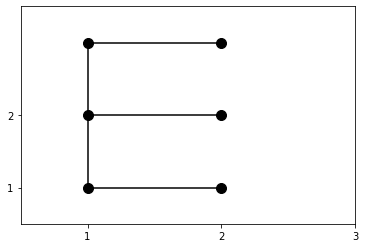

Heuristic alpha beta tree search did not perform the optimal move for Board 0


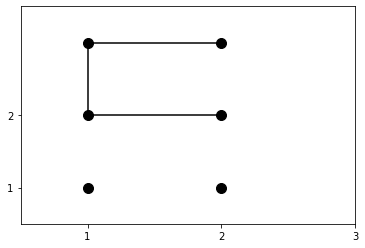

Heuristic alpha beta tree search performed 1 optimal move(s) for Board 1


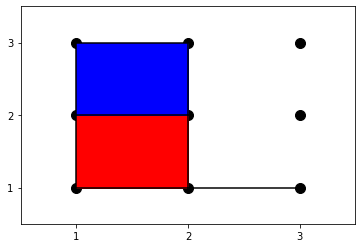

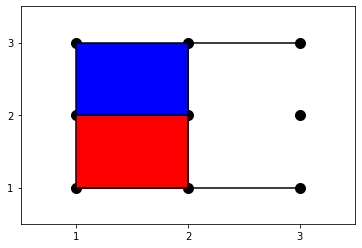

Heuristic alpha beta tree search performed 2 optimal move(s) for Board 2


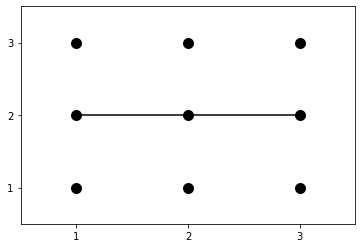

Heuristic alpha beta tree search performed 1 optimal move(s) for Board 3


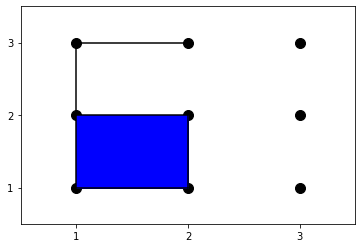

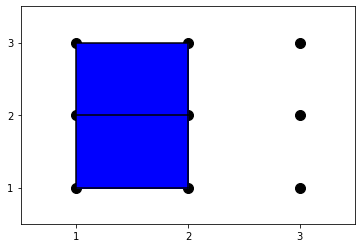

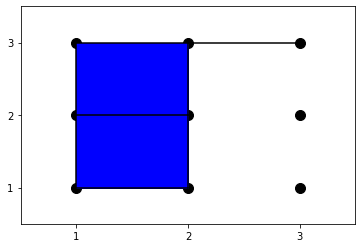

Heuristic alpha beta tree search performed 3 optimal move(s) for Board 4


In [221]:
# Run the agent on each.
for i, curr_board in enumerate(boards):
    is_optimal = test_move(heuristic_ab_search_player, start_board=curr_board, show_res_board=True)
    if (is_optimal >= 0.995):
        print("Heuristic alpha beta tree search performed",int(is_optimal),"optimal move(s) for Board",i)
    else:
        print("Heuristic alpha beta tree search did not perform the optimal move for Board",i)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

The time appears to have a relationship between $O(n)$ and $O(n\log n)$ relationship with column size.This makes sense as adding an extra column introduces $n$ additional nodes to traverse in any given level of the game tree, but depth will remain unchanged due to the cutoff.

Times are noted in printouts below.

In [219]:
# Your code/ answer goes here.
import time 

# Your code/ answer goes here.
board_sizes = [(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(3,10)]

# FIXME: Insufferably long move times for any board of size > 3x3. Is that expected?
for board_size in board_sizes:
    t_i = time.time()
    test_move(heuristic_ab_search_player,start_board=empty_board(board_size[0],board_size[1]))
    t_f = time.time()
    print("A %s board took %.5f seconds to make a move." % (board_size,t_f-t_i))

A (3, 4) board took 0.36511 seconds to make a move.
A (3, 5) board took 0.78560 seconds to make a move.
A (3, 6) board took 1.67792 seconds to make a move.
A (3, 7) board took 3.31352 seconds to make a move.
A (3, 8) board took 5.90531 seconds to make a move.
A (3, 9) board took 9.98929 seconds to make a move.
A (3, 10) board took 16.03852 seconds to make a move.


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

We define a second heuristic alpha beta search player, which performs the same heuristic alpha beta search algorithm with the following changes:

- $w1=2$ (was 3) -- Decreased propensity to chase after L shapes or parallel lines.
- $w2=4$ (was 2) -- Increased propensity to avoid C shapes.
- $w3=2$ (was 1) -- Increased propensity to be "greedy" -- that is, chase after a box when it's available.
- cutoff $=4$ (was 5) -- More evaluating and judging, less percieving.

In [220]:
def eval_fun_2(board, player = 1):
    return eval_fun(board,player,w1 = 2, w2 = 4, w3 = 2, DEBUG = 0)

def heuristic_ab_search_player_2(board, player=None, order_fun = None):
    return heuristic_ab_search(board.copy(),player = player, cutoff=4, eval_fun=eval_fun_2)["move"]

We pit the heuristic alpha beta search player defined and tested above against this new agent and analyze the moves and results.

Player 1 placed line ( v 1 1 )
Player -1 placed line ( h 0 2 )
Player 1 placed line ( h 1 1 )
Player -1 placed line ( h 0 0 )
Player 1 placed line ( v 2 0 )
Player -1 placed line ( v 2 3 )
Player 1 placed line ( h 3 1 )
Player -1 placed line ( h 3 0 )
Player 1 placed line ( h 3 2 )
Player -1 placed line ( v 0 0 )
Player 1 placed line ( v 1 3 )
Player -1 placed line ( v 0 1 )
Player 1 placed line ( h 2 0 )
Player -1 placed line ( h 1 0 )
Player -1 filled a box! Player 1 's turn skipped
Player -1 placed line ( v 1 0 )
Player -1 filled a box! Player 1 's turn skipped
Player -1 placed line ( h 2 1 )
Player 1 placed line ( h 0 1 )
Player -1 placed line ( v 0 2 )
Player -1 filled a box! Player 1 's turn skipped
Player -1 placed line ( h 1 2 )
Player 1 placed line ( v 0 3 )
Player 1 filled a box! Player -1 's turn skipped
Player 1 placed line ( v 1 2 )
Player 1 filled a box! Player -1 's turn skipped
Player 1 placed line ( v 2 1 )
Player 1 filled a box! Player -1 's turn skipped
Player 1 plac

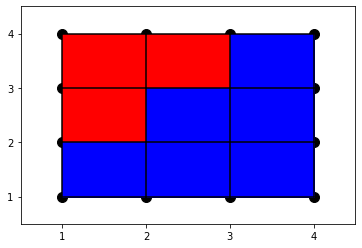

{1: 1, -1: 0, 0: 0}

In [197]:
# Your code/ answer goes here.
play(heuristic_ab_search_player, heuristic_ab_search_player_2,show_final_board=True, print_moves=True)

### Observations from Play Time:

Player blue (the original more "assertive" player) won.

Blue:

- Started at the left-center of the board, following move ordering principles.
- Blue went for the L shape right away, affirming its greater "assertive" tendencies (greater propensity to chase L shapes).
- Did a good job avoiding C shapes at the beginning of the game.
- Was GIFTED a C shape to create the first box, but didn't take it. Unfortunate.

Red:

- Red didn't aggressively form L shapes at the beginning of the game like blue initially did.
- Red was also the first to place a C shape, which contradicts its increased propensity to avoid C shapes. This is likely due to Minimax Search + Smaller cutoff distance.
- Was given an opportunity to fill in 3 boxes at once, but it only filled the first two.
- As a result, blue was given an opportunity to fill in EVERY SINGLE one of its 5 boxes at once and win the game. Ouch.

### Takeaways: 

- There were a lot of opportunities for either player to increase its utility, but it didn't take them for some reason. Perhaps minimax search percieved that the other player would find ways to create chains of boxes as a result of them taking that box and placing another line.
- It appears these strategies of avoiding C shapes and creating parallel lines led to a lot of "edge-hugging" after those initial lines placed by blue occurred.
- These agents would need a lot of work to be competitive. I unfortunately ran out of time for this assignment, but I plan to implement a Monte-Carlo Tree Search algorithm with a more nuanced utility function. 

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:
# Your code/ answer goes here.